# Librerías

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib.image import imread
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Funciones útiles

In [34]:
def resizeImg(path, size):
    img = Image.open(path)

    width, height = img.size
    aspectRatio = width / height

    if aspectRatio < (size[0] / size[1]):
        nHeight = size[1]
        nWidth = int(size[1] * aspectRatio)
    else:
        nWidth = size[0]
        nHeight = int(size[0] / aspectRatio)

    resizedImg = img.resize((nWidth, nHeight), Image.Resampling.LANCZOS)

    newImg = Image.new("RGB", size, (255, 255, 255))

    xOffset = (size[0] - nWidth) // 2
    yOffset = (size[1] - nHeight) // 2
    newImg.paste(resizedImg, (xOffset, yOffset))

    return newImg

# Extracción de datos

In [2]:
testDir = './test'
trainDir = './train'

In [3]:
dataframe = pd.read_csv('./data/data_encoded.csv')

In [4]:
train_df, val_df = train_test_split(dataframe, test_size=0.2, random_state=1)

## Visualización de una imagen

In [16]:
os.listdir(trainDir)[0]

'101_initial_1_1309_1309.JPG'

In [20]:
img_para = imread(trainDir + '/101_initial_1_1309_1309.JPG')
img_para

array([[[224, 237, 255],
        [224, 237, 255],
        [225, 238, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[221, 234, 253],
        [222, 235, 254],
        [222, 235, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[217, 232, 253],
        [219, 234, 255],
        [219, 234, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 21,  23,  12],
        [ 25,  27,  14],
        [ 26,  27,  13],
        ...,
        [ 51,  57,  29],
        [ 57,  61,  36],
        [ 59,  63,  40]],

       [[ 22,  25,  14],
        [ 25,  29,  15],
        [ 27,  30,  13],
        ...,
        [ 43,  47,  20],
        [ 52,  54,  30],
        [ 57,  59,  37]],

       [[ 22,  25,  14],
        [ 24,  28,  14],
        [ 30,  33,  16],
        ...,
        [ 43,  47,  20],
        [ 53,  53,  29],
        [ 58,  57,  36]]

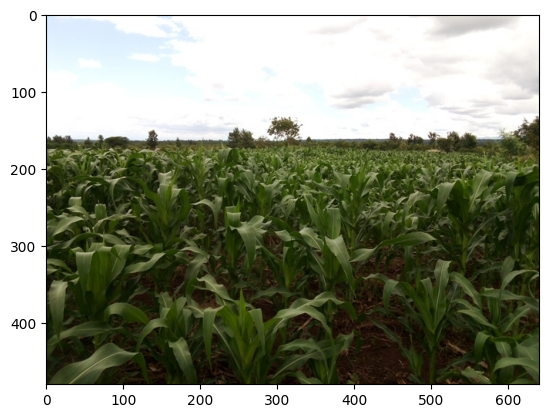

In [22]:
plt.imshow(img_para)

## Tamaño promedio

In [23]:
dim1 = []
dim2 = []

for nombre_imagen in os.listdir(testDir):
    
    img = imread(testDir + '/' + nombre_imagen)
    d1,d2,colores = img.shape
    dim1.append(d1)
    dim2.append(d2)

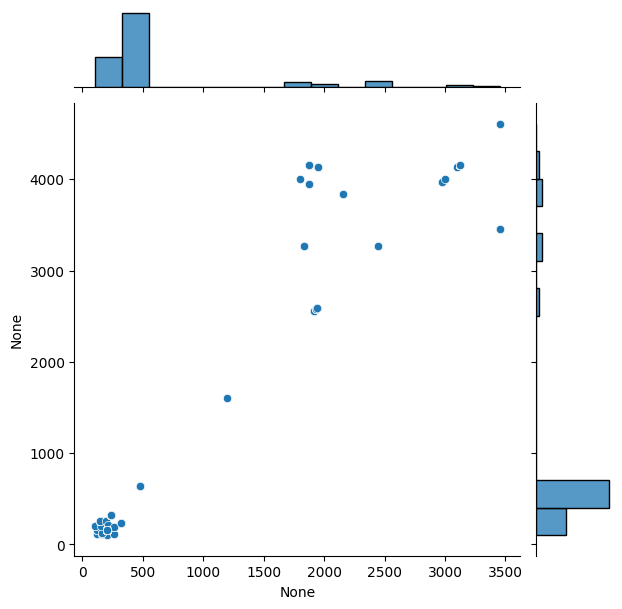

In [26]:
sns.jointplot(x = dim1, y = dim2)

In [27]:
np.mean(dim1)

722.979914579245

In [28]:
np.mean(dim2)

1035.9407826388087

## Redimensión del conjunto de datos

In [6]:
size = (722, 1035)
formaImagen = (722, 1035, 3)

folder = "train_resized"
os.makedirs(folder, exist_ok=True)

for _, row in dataframe.iterrows():
    filename = row['filename']
    path = os.path.join(trainDir, filename)
    output = os.path.join(folder, filename)

    if os.path.exists(output):
        continue
    else:
        if os.path.exists(path):
            resized = resizeImg(path, size)
            resized.save(output)
        else:
            print(f"File not found: {path}")

print("Resizing and saving complete.")

Resizing and saving complete.


# Entrenar modelo

In [7]:
tamanio_tanda = 32

gen_imagen = ImageDataGenerator(
                  rescale=1./255,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True
)

train_generator = gen_imagen.flow_from_dataframe(
                      train_df,
                      directory="./train_resized",
                      x_col="filename",
                      y_col="extent",
                      target_size=size,
                      color_mode = 'rgb',
                      batch_size=tamanio_tanda,
                      class_mode="other"
)

val_generator = gen_imagen.flow_from_dataframe(
                  val_df,
                  directory="./train_resized",
                  x_col="filename",
                  y_col="extent",
                  target_size=size,
                  color_mode = 'rgb',
                  batch_size=tamanio_tanda,
                  class_mode="other",
                  shuffle = False
)

Found 20854 validated image filenames.
Found 5214 validated image filenames.


## Modelo CNN

In [8]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = formaImagen, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = formaImagen, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = formaImagen, activation = 'relu',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='linear', name='extent'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

c:\Users\ealva\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 720, 1033, 32)  │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 360, 516, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 358, 514, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 179, 257, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 177, 255, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 88, 127, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1430528)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   183,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ extent (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,201,089 (698.86 MB)

 Trainable params: 183,201,089 (698.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
resultados = model.fit(train_generator,
                       epochs=5,
                       validation_data=val_generator,
                       callbacks=[early_stop]
                    )

Epoch 1/5
 27/652 ━━━━━━━━━━━━━━━━━━━━ 23:00:37 133s/step - loss: 14280.7217 - mse: 14280.7217